In [1]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [2]:
env = gym_super_mario_bros.make('SuperMarioBros-v3', apply_api_compatibility=True)
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [3]:
env.observation_space.shape

(240, 256, 3)

In [4]:
env.action_space

Discrete(7)

In [ ]:
done = True
for step in range(5000):
    if done:
        state = env.reset()
    new_state, reward, done, truncated, info = env.step(env.action_space.sample())
    env.render()

env.close()

In [5]:
env.reset()

(array([[[104, 136, 252],
         [104, 136, 252],
         [104, 136, 252],
         ...,
         [104, 136, 252],
         [104, 136, 252],
         [104, 136, 252]],
 
        [[104, 136, 252],
         [104, 136, 252],
         [104, 136, 252],
         ...,
         [104, 136, 252],
         [104, 136, 252],
         [104, 136, 252]],
 
        [[104, 136, 252],
         [104, 136, 252],
         [104, 136, 252],
         ...,
         [104, 136, 252],
         [104, 136, 252],
         [104, 136, 252]],
 
        ...,
 
        [[228,  92,  16],
         [228,  92,  16],
         [228,  92,  16],
         ...,
         [228,  92,  16],
         [228,  92,  16],
         [228,  92,  16]],
 
        [[228,  92,  16],
         [228,  92,  16],
         [228,  92,  16],
         ...,
         [228,  92,  16],
         [228,  92,  16],
         [228,  92,  16]],
 
        [[228,  92,  16],
         [228,  92,  16],
         [228,  92,  16],
         ...,
         [228,  92,  16],
  

In [6]:
len(env.step(1))

C:\Users\Dell\Documents\ML\RL_env\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


5

In [7]:
env.step(1)[0]

array([[[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       [[104, 136, 252],
        [104, 136, 252],
        [104, 136, 252],
        ...,
        [104, 136, 252],
        [104, 136, 252],
        [104, 136, 252]],

       ...,

       [[228,  92,  16],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [228,  92,  16],
        [228,  92,  16]],

       [[228,  92,  16],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [228,  92,  16],
        [228,  92,  16]],

       [[228,  92,  16],
        [228,  92,  16],
        [228,  92,  16],
        ...,
        [228,  92,  16],
        [228,  92,  16],
        [228,  92,  16]]

In [8]:
env.step(1)[1]

0

In [9]:
env.step(1)[2]

False

In [10]:
env.step(1)[3]

False

In [11]:
env.step(1)[4]

{'coins': 0,
 'flag_get': False,
 'life': 2,
 'score': 0,
 'stage': 1,
 'status': 'small',
 'time': 400,
 'world': 1,
 'x_pos': 40,
 'x_pos_screen': 40,
 'y_pos': 79}

# Preprocessing env

In [12]:
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [13]:
env = gym_super_mario_bros.make('SuperMarioBros-v3', apply_api_compatibility=True,render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)

#Grayscale
env = GrayScaleObservation(env, keep_dim=True)

def make_env():
    return env

# Wrap inside DummyVecEnv without passing seed argument to reset
env = DummyVecEnv([make_env])
env = VecFrameStack(env, 4, channels_order='last')

C:\Users\Dell\Documents\ML\RL_env\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
C:\Users\Dell\Documents\ML\RL_env\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [14]:
state = env.reset()

In [39]:
actions = [env.action_space.sample() for _ in range(env.num_envs)]  # Sample actions for each environment
state, rewards, dones, infos = env.step([5])

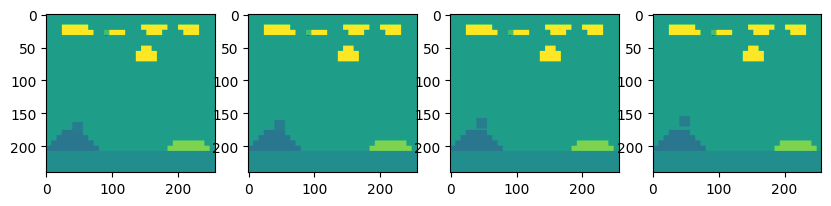

In [40]:
plt.figure(figsize=(10, 8))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# Training

In [41]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [42]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path=  save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [43]:
Checkpoint_dir = './train/'
Log_dir = './logs/'

In [44]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=Checkpoint_dir)

In [45]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=Log_dir, learning_rate=0.000001, n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
model.learn(total_timesteps=100000, callback=callback)

# Testing

In [46]:
model.save('TestModel')

In [55]:
model = PPO.load('./train/best_model_90000.zip')

In [56]:
state = env.reset()

In [57]:
model.predict(state)

(array([1], dtype=int64), None)

In [ ]:
state = env.reset()

while True:
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()